In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 数据预览和预处理

In [2]:
stock = pd.read_csv("./data/Tesla.csv")
stock.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [3]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1692 non-null   datetime64[ns]
 1   Open       1692 non-null   float64       
 2   High       1692 non-null   float64       
 3   Low        1692 non-null   float64       
 4   Close      1692 non-null   float64       
 5   Volume     1692 non-null   int64         
 6   Adj Close  1692 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 92.7 KB


In [4]:
stock.describe(include = 'all', datetime_is_numeric=True)

,Date,Open,High,Low,Close,Volume,Adj Close
count,1692,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,2013-11-06 02:53:37.021276416,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
min,2010-06-29 00:00:00,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,2012-03-01 18:00:00,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,2013-11-05 12:00:00,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,2015-07-14 06:00:00,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,2017-03-17 00:00:00,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009
std,NaN,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187


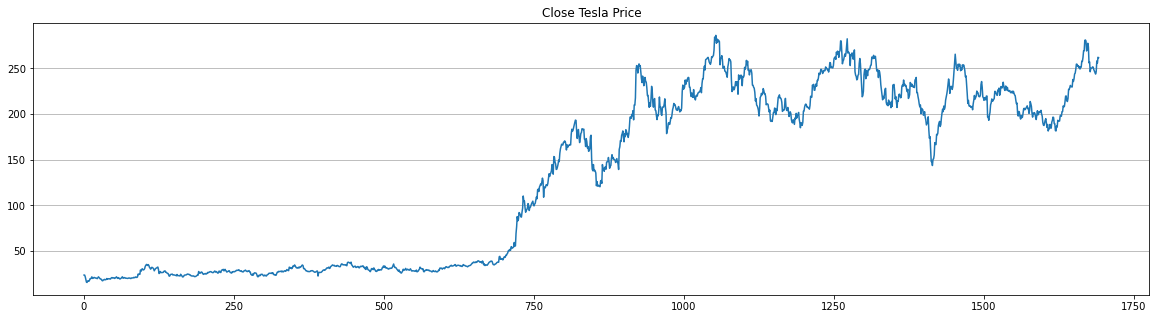

In [5]:
plt.figure(figsize = (20, 5))
day = np.arange(0, stock.shape[0], 1) #按天数依次排列
plt.plot(day, stock['Close'])
plt.title("Close Tesla Price") #为了不进行字体转换建议全英文绘制
plt.grid(which = "major", axis = "y")
plt.show()

对于RNN及相关算法的模型,我们需要一个参数: time_step. 这样我们就可以使模型在预测时仅考虑time_step内的价格,从而大幅度减小过于久远的历史交易数据对未来数据的影响

这里设置time_step = 5(若无特殊节假日,美股5天=一周,周六周日休市)

In [6]:
time_step = 5
day_to_predict = 30 # 需要预测多少天的股价
data_to_use = stock['Close'].values

scaler = StandardScaler()
scaled_stock = scaler.fit_transform(data_to_use.reshape(-1, 1)) #-1的意思是这里的形状留空,由其余维度的形状计算得出.若有20个数据,则(-1, 1)会将其变为20列,1行;(1, -1)会将其变为20行,一列.如果不使用reshape,后面的截断会报错

train = scaled_stock[:-day_to_predict]
test = scaled_stock[-day_to_predict - time_step:]

print("训练集一共有{}天的股价数据".format(train.shape[0]))
print("测试集一共有{}天的股价数据".format(test.shape[0]))

训练集一共有1662天的股价数据
测试集一共有35天的股价数据


In [7]:
train_x, train_y = [], []
for i in range(time_step, train.shape[0]) : 
    train_x.append(train[i - time_step : i, 0]) #前五天作为变量
    train_y.append(train[i, 0]) #后一天作为预测

train_x, train_y = np.array(train_x), np.array(train_y) #转为numpy array,否则是list
print(train_x[:5]) #train_x的前五个元素长这样
print(train_x.shape)
print('-------------')
print(train_y[:5]) #train_y的前五个元素长这样
print(train_y.shape)


[[-1.15117251 -1.15180886 -1.17164229 -1.20091512 -1.23368799]
 [-1.15180886 -1.17164229 -1.20091512 -1.23368799 -1.23697589]
 [-1.17164229 -1.20091512 -1.23368799 -1.23697589 -1.21936977]
 [-1.20091512 -1.23368799 -1.23697589 -1.21936977 -1.22000613]
 [-1.23368799 -1.23697589 -1.21936977 -1.22000613 -1.22371827]]
(1657, 5)
-------------
[-1.23697589 -1.21936977 -1.22000613 -1.22371827 -1.21215762]
(1657,)


In [8]:
# 对于test如法炮制
test_x, test_y = [], []
for i in range(time_step, test.shape[0]) : 
    test_x.append(test[i - time_step : i, 0])
    test_y.append(test[i, 0])
test_x, test_y = np.array(test_x), np.array(test_y)

reshape一下以适用于tensorflow

In [9]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))

In [10]:
train_x.shape

(1657, 5, 1)

# 建模

In [11]:
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam #综合来讲adam是目前最常用的优化器.sgd虽然能达到极小值,但耗时较长,且容易陷入局部极小值

In [12]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)

In [13]:
model = Sequential() #建立一个空模型

# 添加各种层
model.add(LSTM(units = 128, return_sequences = True, input_shape = (train_x.shape[1], 1,))) #留空是因为使用了批次输入,这里留空会在打印model summary中被计为None
# 参数数量=4 * ((units * units) + (units * inputs) + units_bias), 其中unit_bias是Σwx+b中的b,数量等于units
# 乘以4是因为,lstm与simple rnn相比多了更新门,遗忘门和输出门
# 第一层的inputs是1,因为只输入一天的股价
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(units = 1, activation = "relu"))

# 关于优化方法的比较,详见: https://ruder.io/optimizing-gradient-descent/
model.compile(Adam(lr = 0.001), loss = ["mean_squared_error"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               1

In [15]:
train_history = model.fit(train_x, train_y, epochs = 300, batch_size = 16, callbacks = [reduce_lr, monitor_es])

Epoch 1/300
104/104 [==============================] - 1s 10ms/step - loss: 0.5662
Epoch 2/300
104/104 [==============================] - 1s 11ms/step - loss: 0.5304
Epoch 3/300
104/104 [==============================] - 1s 11ms/step - loss: 0.5306
Epoch 4/300
104/104 [==============================] - 1s 10ms/step - loss: 0.5319
Epoch 5/300
104/104 [==============================] - 1s 11ms/step - loss: 0.5294
Epoch 6/300
104/104 [==============================] - 1s 11ms/step - loss: 0.5310
Epoch 7/300
104/104 [==============================] - 1s 10ms/step - loss: 0.5294
Epoch 8/300
104/104 [==============================] - 1s 9ms/step - loss: 0.5314
Epoch 9/300
104/104 [==============================] - 1s 9ms/step - loss: 0.5288
Epoch 10/300
104/104 [==============================] - 1s 10ms/step - loss: 0.5287
Epoch 11/300
104/104 [==============================] - 1s 10ms/step - loss: 0.5280
Epoch 12/300
104/104 [==============================] - 1s 11ms/step - loss: 0.5272
Epo

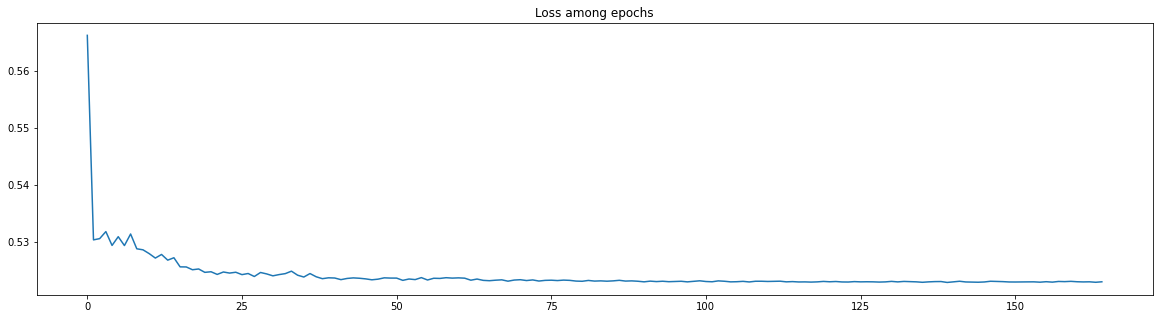

In [16]:
plt.figure(figsize = (20, 5))
plt.plot(train_history.history["loss"])
plt.title("Loss among epochs")
plt.show()

# 模型的存储

In [17]:
import os

In [18]:
if not os.path.exists('./model'):
    os.mkdir('./model')
model_json = model.to_json()
# .json保存model structure
with open("./model/tesla.json", "w") as json_file:
  json_file.write(model_json)
# .h5保存model weights
model.save_weights("./model/tesla.h5")

In [19]:
from tensorflow.keras.models import model_from_json

json_file = open('./model/tesla.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("./model/tesla.h5")
print("模型已加载")

模型已加载


In [20]:
loaded_model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
real_prices = test[time_step:]
real_prices = scaler.inverse_transform(real_prices) #还原

结果比较

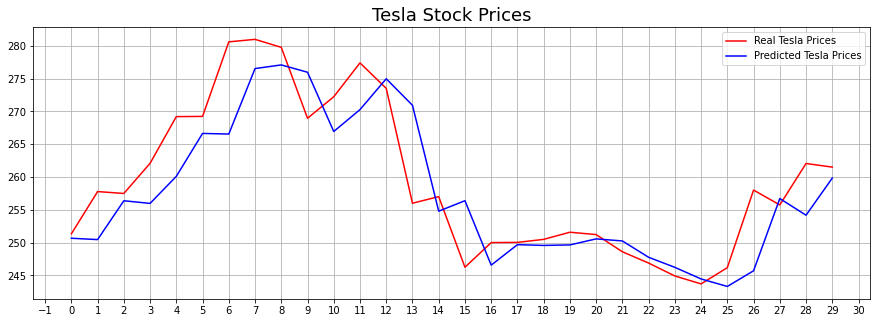

In [22]:
predicted_prices = loaded_model.predict(test_x)
predicted_prices = scaler.inverse_transform(predicted_prices)

x = np.arange(0, day_to_predict, 1)

plt.figure(figsize = (15, 5))
plt.plot(x, real_prices, color = "red", label = "Real Tesla Prices")
plt.plot(x, predicted_prices, color = "blue", label = "Predicted Tesla Prices")
plt.title("Tesla Stock Prices", fontsize = 18)
plt.legend()
# 设置刻度,以一天为单位
x_major_locator=plt.MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.grid(which = "major", axis = "both")
plt.show()